In [1]:
from pystan import StanModel
import pystan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
d = pd.read_csv('data-attendance-2.txt')
d.Score/=200
d["ratio"] = np.round(d.Y/d.M,3)
data = d.to_dict('list')
data['N'] = len(d)
del data['PersonID']

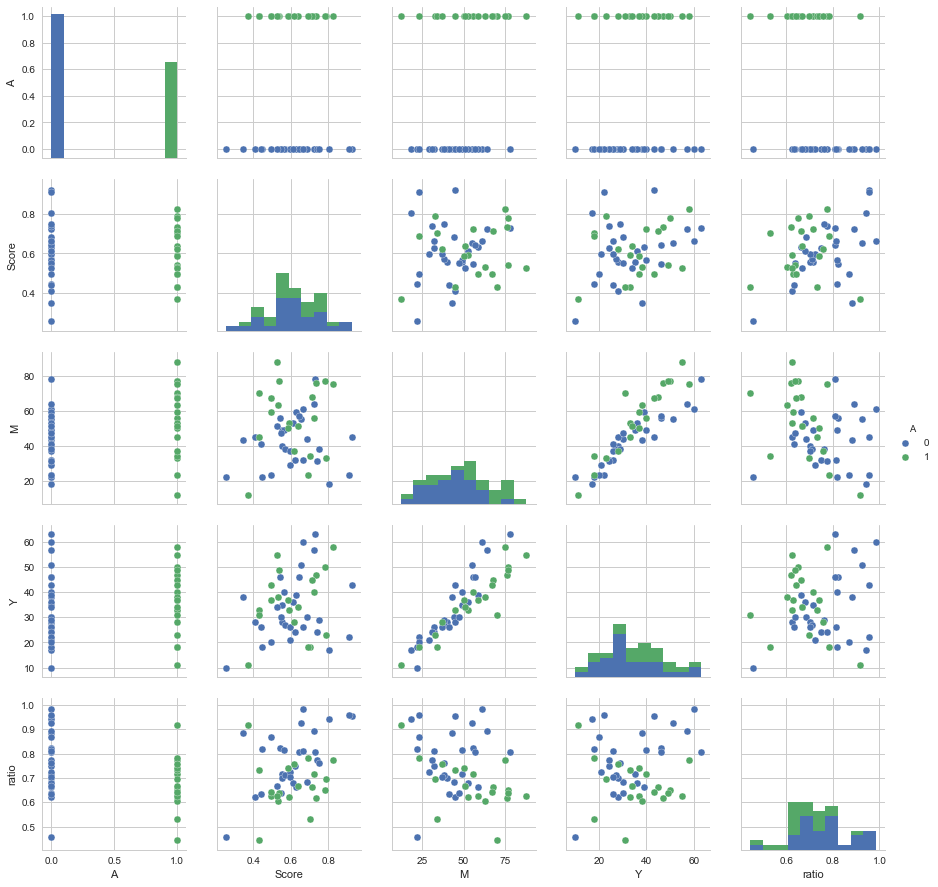

In [3]:
df_data = pd.DataFrame(data, columns=['A', 'Score', 'M', 'Y', 'ratio'])
sns.pairplot(df_data, hue='A')

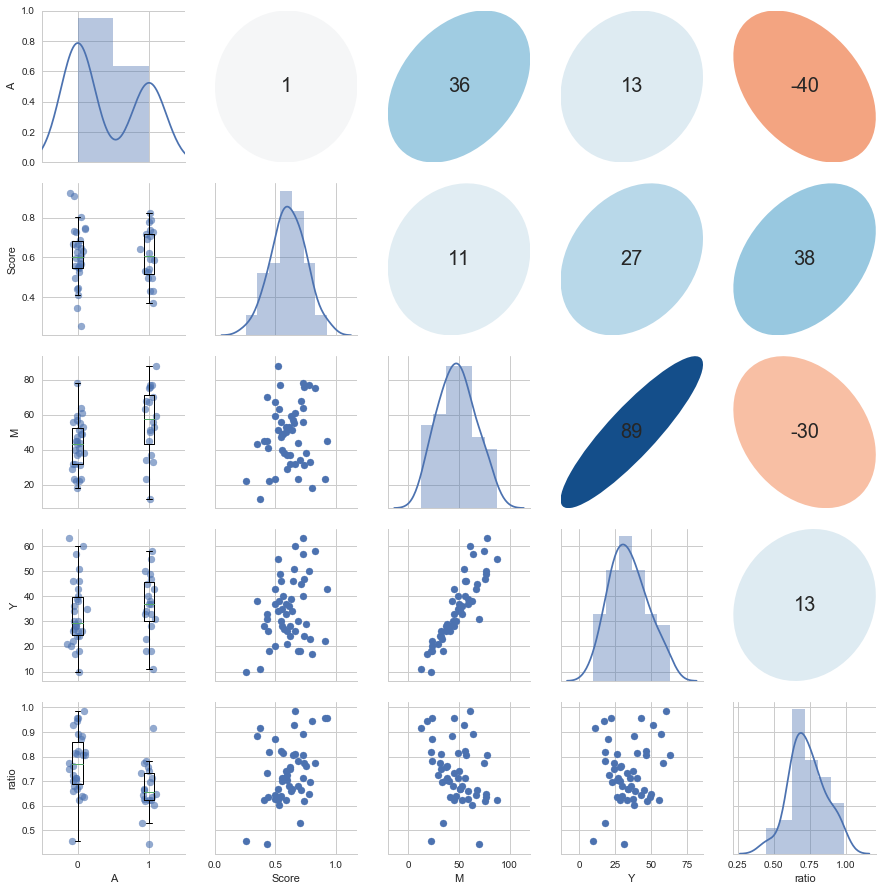

In [11]:
%run Dispatcher.py
g = sns.PairGrid(d[["A","Score","M","Y","ratio"]], diag_sharey=False)
d_plot = Dispatcher()
# 対角成分
g.map_diag(d_plot.diag)
# 下三角成分
g.map_lower(d_plot.comb);
# 上三角成分
g.map_upper(d_plot.ellipse);

In [13]:
stanmodel = StanModel(file='model5-4.stan')

In [25]:
fit = stanmodel.sampling(data=data, seed=17, thin = 2, warmup=500, n_jobs=-1)

In [26]:
fit

Inference for Stan model: anon_model_8043971f7ecd16652c04a2eb6c63b87b.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup draws per chain=750, total post-warmup draws=3000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           0.08  5.2e-3   0.23  -0.39  -0.07   0.08   0.24   0.54   1946    1.0
b2          -0.62  2.1e-3    0.1  -0.81  -0.68  -0.62  -0.55  -0.43   2199    1.0
b3           1.92  8.5e-3   0.37    1.2   1.67   1.92   2.16   2.66   1911    1.0
q[0]         0.68  5.5e-4   0.03   0.62   0.66   0.68   0.69   0.72   2085    1.0
q[1]          0.7  3.4e-4   0.02   0.67   0.69    0.7   0.71   0.73   2317    1.0
q[2]         0.78  2.3e-4   0.01   0.76   0.77   0.78   0.79   0.81   2604    1.0
q[3]         0.57  4.8e-4   0.02   0.53   0.56   0.57   0.59   0.61   2224    1.0
q[4]         0.73  3.9e-4   0.02   0.69   0.71   0.73   0.74   0.76   2201    1.0
q[5]         0.79  2.4e-4   0.01   0.77   0.79    0.8    0.8   0.82   2520 

In [27]:
from scipy.stats import gaussian_kde
fit.model_pars.append("lp__")
def find_map(data):
    kde = gaussian_kde(data)
    x_range = np.linspace(data.min(), data.max(), 501)
    eval_kde = kde.evaluate(x_range)
    return x_range[np.argmax(eval_kde)]

In [28]:
map = []
for i in fit.model_pars:
    print(i)
    if i in fit.constrained_param_names() or i == 'lp__':
        map.append(find_map(fit[i]))
    else:
        for j in range(0, fit[i].shape[1]):
            map.append(find_map(fit[i][:, j]))

b1
b2
b3
q
y_pred
lp__


In [29]:
def stanfit_to_dataframe(fit):
    summary = fit.summary()
    columns = summary['summary_colnames']
    index = summary['summary_rownames']
    data = summary['summary']
    return pd.DataFrame(data, index, columns)

In [31]:
fitdf = stanfit_to_dataframe(fit)
fitdf["map"] = map
fitdf

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat,map
b1,0.080894,0.005225,0.230495,-0.390078,-0.073804,0.082109,0.237600,0.536838,1946.0,0.999719,0.080086
b2,-0.617464,0.002074,0.097235,-0.808635,-0.681406,-0.619727,-0.551399,-0.428115,2199.0,1.000494,-0.643772
b3,1.917243,0.008451,0.369455,1.204412,1.669490,1.917336,2.160491,2.664682,1911.0,0.999860,1.945679
q[0],0.676995,0.000553,0.025241,0.623817,0.660323,0.677954,0.694731,0.723935,2085.0,0.999652,0.680206
q[1],0.701033,0.000337,0.016206,0.669476,0.690270,0.700921,0.712031,0.732673,2317.0,0.999254,0.700802
q[2],0.782071,0.000235,0.011975,0.757846,0.773722,0.782546,0.790172,0.805085,2604.0,0.999846,0.785377
q[3],0.571318,0.000482,0.022722,0.527063,0.555461,0.571377,0.587147,0.614456,2224.0,1.000112,0.570917
q[4],0.726333,0.000392,0.018396,0.688990,0.714088,0.726567,0.738740,0.762199,2201.0,0.999292,0.727207
q[5],0.794822,0.000240,0.012072,0.770992,0.786476,0.795254,0.802867,0.818266,2520.0,0.999943,0.797059
q[6],0.758352,0.000257,0.013008,0.732601,0.749452,0.758817,0.767313,0.782729,2554.0,0.999684,0.761068


In [42]:
mc = fit.extract()
df = pd.DataFrame({"b1":mc['b1'], "b2":mc["b2"], "b3":mc["b3"], 
             "q1":mc["q"][:, 0], "q50":mc["q"][:, 49], "lp__":mc["lp__"]})
df

,b1,b2,b3,lp__,q1,q50
0,-0.139301,-0.688156,2.310766,-1388.815537,0.658792,0.578440
1,-0.170177,-0.613178,2.381308,-1388.928326,0.657320,0.597580
2,0.103277,-0.595671,1.855577,-1387.892620,0.677750,0.604946
3,0.064511,-0.812095,2.174768,-1390.470105,0.693133,0.581498
4,0.267454,-0.590022,1.610662,-1388.284176,0.694901,0.616498
5,0.066442,-0.653710,2.132526,-1390.238477,0.690437,0.614989
6,0.284863,-0.649466,1.710316,-1388.976546,0.705769,0.618221
7,0.202489,-0.802685,1.903774,-1389.853271,0.702512,0.584718
8,0.202193,-0.653912,1.786858,-1388.113000,0.693952,0.606536
9,0.277601,-0.768284,1.818572,-1389.933794,0.711978,0.600970


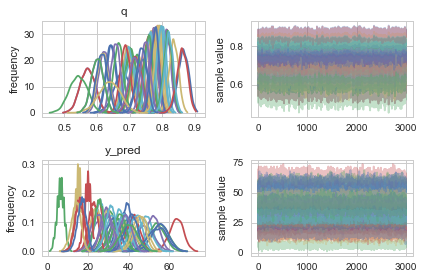

In [32]:
fit.traceplot(pars=['q','y_pred']).tight_layout()

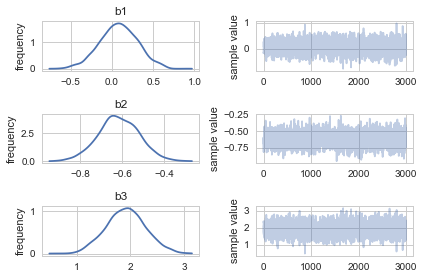

In [33]:
fit.traceplot(pars=['b1','b2','b3']).tight_layout()

In [43]:
fitdf_pred = fitdf.loc['y_pred[0]': 'y_pred[49]']
fitdf_q = fitdf.loc['q[0]': 'q[49]']

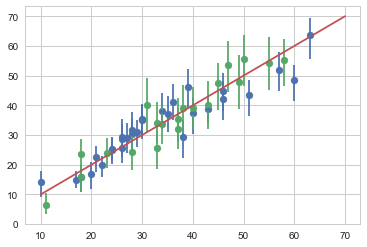

In [35]:
plt.scatter(d[d.A==0].Y, fitdf_pred[d["A"].values==0]["mean"])
plt.scatter(d[d.A==1].Y, fitdf_pred[d["A"].values==1]["mean"])
dy0_1 = fitdf_pred[d["A"].values==0]['50%'] - fitdf_pred[d["A"].values==0]['2.5%']
dy0_2 = fitdf_pred[d["A"].values==0]['97.5%'] - fitdf_pred[d["A"].values==0]['50%']
dy1_1 = fitdf_pred[d["A"].values==1]['50%'] - fitdf_pred[d["A"].values==1]['2.5%']
dy1_2 = fitdf_pred[d["A"].values==1]['97.5%'] - fitdf_pred[d["A"].values==1]['50%']
plt.errorbar(d[d.A==0].Y, fitdf_pred[d["A"].values==0]["mean"], yerr=[dy0_1, dy0_2], fmt='.');
plt.errorbar(d[d.A==1].Y, fitdf_pred[d["A"].values==1]["mean"], yerr=[dy1_1, dy1_2], fmt='.');
plt.plot(np.linspace( 10, 70), np.linspace(10, 70))

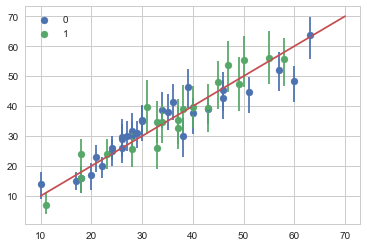

In [51]:
plt.scatter(d[d.A==0].Y, fitdf_pred[d["A"].values==0]["map"], label = 0)
plt.scatter(d[d.A==1].Y, fitdf_pred[d["A"].values==1]["map"], label = 1)
dy0_1 = fitdf_pred[d["A"].values==0]['50%'] - fitdf_pred[d["A"].values==0]['2.5%']
dy0_2 = fitdf_pred[d["A"].values==0]['97.5%'] - fitdf_pred[d["A"].values==0]['50%']
dy1_1 = fitdf_pred[d["A"].values==1]['50%'] - fitdf_pred[d["A"].values==1]['2.5%']
dy1_2 = fitdf_pred[d["A"].values==1]['97.5%'] - fitdf_pred[d["A"].values==1]['50%']
plt.errorbar(d[d.A==0].Y, fitdf_pred[d["A"].values==0]["map"], yerr=[dy0_1, dy0_2], fmt='.', label =None);
plt.errorbar(d[d.A==1].Y, fitdf_pred[d["A"].values==1]["map"], yerr=[dy1_1, dy1_2], fmt='.', label =None);
plt.plot(np.linspace( 10, 70), np.linspace(10, 70))
plt.legend()

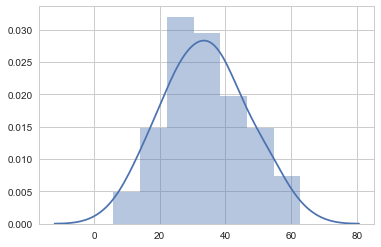

In [16]:
fitdf_q = fitdf.loc['q[0]': 'q[49]']
sns.distplot(fitdf_pred['mean'].values -  fitdf_q['mean'].values);